## Pull data from pixelstarships api, upload to an excel file

In [76]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-

# ----- Packages ------------------------------------------------------
import csv
import datetime
import os
import urllib.parse
import urllib.request
import xml.etree.ElementTree


PSS_CHARS_FILE = 'pss-chars.txt'
PSS_CHARS_RAW_FILE = 'pss-chars-raw.txt'
PSS_LINKS_FILE = 'links.csv'
MAXIMUM_CHARACTERS = 1900

In [77]:
def save_raw_text(raw_text, filename):
    try:
        with open(filename, 'w') as f:
            f.write(raw_text)
    except:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(raw_text)

def get_data_from_url(url):
    data = urllib.request.urlopen(url).read()
    return data.decode('utf-8')

def load_data_from_url(filename, url, refresh='auto'):
    if os.path.isfile(filename) and refresh != 'true':
        if refresh == 'auto':
            if is_old_file(filename, max_seconds=3600):
                raw_text = get_data_from_url(url)
                save_raw_text(raw_text, filename)
                return raw_text
        with open(filename, 'r') as f:
            raw_text = f.read()
    else:
        raw_text = get_data_from_url(url)
        save_raw_text(raw_text, filename)
    return raw_text

def xmltree_to_dict2(raw_text, key=None):
    root = xml.etree.ElementTree.fromstring(raw_text)
    for c in root:
        d = {}
        for cc in c:
            if key is None:
                d = cc.attrib
            else:
                d[cc.attrib[key]] = cc.attrib
    return d

def xmltree_to_dict3(raw_text, key):
    root = xml.etree.ElementTree.fromstring(raw_text)
    for c in root:
        for cc in c:
            d = {}
            for ccc in cc:
                d[ccc.attrib[key]] = ccc.attrib
    return d


def create_reverse_lookup(d, new_key, new_value):
    """Creates a dictionary of the form:
    {'new_key': 'new_value'}"""
    rlookup = {}
    for key in d.keys():
        item = d[key]
        rlookup[item[new_key]] = item[new_value]
    return rlookup


# ----- Get Production Server -----
def get_production_server():
    url = 'https://api.pixelstarships.com/SettingService/GetLatestVersion3?languageKey=en&deviceType=DeviceTypeAndroid'
    raw_text = get_data_from_url(url)
    d = xmltree_to_dict2(raw_text, key=None)
    return d['ProductionServer']

In [78]:
base_url = 'http://{}/'.format(get_production_server())

def request_new_char_sheet():
    # Download Character Sheet from PSS Servers
    url = base_url + 'CharacterService/ListAllCharacterDesigns?languageKey=en'
    data = urllib.request.urlopen(url).read()
    return data.decode()


def get_char_sheet(refresh='auto'):
    url = base_url + 'CharacterService/ListAllCharacterDesigns?languageKey=en'
    raw_text = load_data_from_url(PSS_CHARS_RAW_FILE, url, refresh=refresh)
    ctbl = xmltree_to_dict3(raw_text, 'CharacterDesignId')
    tbl_i2n = create_reverse_lookup(ctbl, 'CharacterDesignId', 'CharacterDesignName')
    tbl_n2i = create_reverse_lookup(ctbl, 'CharacterDesignName', 'CharacterDesignId')
    rarity = create_reverse_lookup(ctbl, 'CharacterDesignName', 'Rarity')
    return ctbl, tbl_i2n, tbl_n2i, rarity

In [79]:
ctbl, tbl_i2n, tbl_n2i, rarity = get_char_sheet(refresh='true')
txt = ''
for k,v in tbl_i2n.items():
    txt += f'{k},{v}\n'
with open('characters.csv', 'w') as f:
    f.write(txt)

In [80]:
# start with excel file headers
txt = ('CharacterDesignId,CharacterDesignName,RaceType,FinalHp,FinalPilot,FinalAttack,FinalRepair,'
'FinalWeapon,FinalScience,FinalEngine,FireResistance,Rarity,SpecialAbilityType,SpecialAbilityFinalArgument,'
'ProfileSpriteId,WalkingSpeed,RunSpeed,TrainingCapacity,EquipmentMask,CollectionDesignId,Flags,CharacterDesignDescription\n')

# Add character stats
for k in ctbl.keys():
    item=ctbl[k]
    
    txt += f"{item['CharacterDesignId']},"
    txt += f"{item['CharacterDesignName']},"
    txt += f"{item['RaceType']},"
    txt += f"{item['FinalHp']},"
    txt += f"{item['FinalPilot']},"
    txt += f"{item['FinalAttack']},"
    txt += f"{item['FinalRepair']},"
    txt += f"{item['FinalWeapon']},"
    txt += f"{item['FinalScience']},"
    txt += f"{item['FinalEngine']},"
    txt += f"{item['FireResistance']},"
    txt += f"{item['Rarity']},"
    txt += f"{item['SpecialAbilityType']},"
    txt += f"{item['SpecialAbilityFinalArgument']},"
    txt += f"{item['ProfileSpriteId']},"
    txt += f"{item['WalkingSpeed']},"
    txt += f"{item['RunSpeed']},"
    txt += f"{item['TrainingCapacity']},"
    txt += f"{item['EquipmentMask']},"
    txt += f"{item['CollectionDesignId']},"
    txt += f"{item['Flags']},"
    
    desc = item['CharacterDesignDescription'].replace(",", "")
    txt += f'{desc}\n'
    
with open('characters_fulldata.csv', 'w', encoding='utf-8') as f:
    f.write(txt)

## Read data from that excel file into python for ML

In [81]:
import pandas as pd #for data handling
from pandas import ExcelFile # for file reading
import numpy as np # for data manipulation and plotting
from progressbar import ProgressBar # for output monitoring

In [82]:
# import data from excel file
df = pd.read_csv('characters_fulldata.csv')
print("Column headings:")
print(df.columns)

Column headings:
Index(['CharacterDesignId', 'CharacterDesignName', 'RaceType', 'FinalHp',
       'FinalPilot', 'FinalAttack', 'FinalRepair', 'FinalWeapon',
       'FinalScience', 'FinalEngine', 'FireResistance', 'Rarity',
       'SpecialAbilityType', 'SpecialAbilityFinalArgument', 'ProfileSpriteId',
       'WalkingSpeed', 'RunSpeed', 'TrainingCapacity', 'EquipmentMask',
       'CollectionDesignId', 'Flags', 'CharacterDesignDescription'],
      dtype='object')


In [83]:
# drop the columns that don't have real meaning for the model (ex. name, desc, icon, etc)
crew_df = df.drop(['CharacterDesignId', 'ProfileSpriteId', 'CharacterDesignDescription'], axis=1)

In [84]:
crew_df.head()

,CharacterDesignName,RaceType,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,FireResistance,Rarity,SpecialAbilityType,SpecialAbilityFinalArgument,WalkingSpeed,RunSpeed,TrainingCapacity,EquipmentMask,CollectionDesignId,Flags
0,Laura,Unknown,6,18,1.9,1.7,4.0,7,3.0,1,Special,DeductReload,460,1,2,200,62,0,9
1,Lisa,Unknown,6,18,1.9,1.7,7.0,12,4.0,1,Special,HealSelfHp,6,1,2,200,62,0,9
2,Michelle,Unknown,6,18,1.9,1.7,13.0,4,3.0,1,Special,HealSameRoomCharacters,5,1,2,200,62,0,9
3,Bobby,Unknown,6,18,1.9,1.7,3.0,3,14.0,1,Special,AddReload,40,1,2,200,62,0,9
4,Edward,Unknown,6,18,1.9,1.7,3.0,6,4.0,1,Special,DamageToRoom,4,1,2,200,62,0,9


# Push that data into the Wordpress SQL database

In [85]:
# import sys
# !{sys.executable} -m pip install mysql.connector

In [86]:
import mysql.connector

db = mysql.connector.connect(host='162.241.219.104', user='pixelpg4_rigging', passwd='PIXs@tt03fl', db='pixelpg4_crew')
print(db)

crewstats_db = pd.read_sql_query("select * from crew_stats", db)

db.close()

In [87]:
crewstats_db.head()

,CharacterDesignId,CharacterDesignName,RaceType,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,Rarity,SpecialAbilityType,SpecialAbilityFinalArgument,ProfileSpriteId,WalkingSpeed,RunSpeed,TrainingCapacity,EquipmentMask,CollectionDesignId,CharacterDesignDescription
0,1,Laura,Unknown,6,18,2.0,2.0,4,7,3,Special,DeductReload,460,2852,1,2,200,62,0,Space Academy graduate and much loved Capt'n o...


## Add columns for useful features

#### Add columns to flag crew that are particularly good or particularly bad at their given ability

In [129]:
# Normalize ability scores
# (score-mean / stdev)

p = False# for debugging

# get a list of all of the abilities
abilities = crew_df['SpecialAbilityType'].unique()

# this df will hold the mean and stdev values, for calculating
ability_stats_df = pd.DataFrame(columns=['AbilityType', 'm', 's'])

# for each ability, calculate the mean and stdev
for a in abilities:
    if p: print("\ncalculating ability stats for " + a)
    
    tempdf = crew_df[crew_df.SpecialAbilityType == a]
    stats = tempdf['SpecialAbilityFinalArgument']
      
    stats_entry = {'AbilityType': a, 'm': np.mean(stats), 's': np.std(stats)}
    if p: print(stats_entry)
    
    ability_stats_df = ability_stats_df.append(stats_entry, ignore_index=True)
    
if p: ability_stats_df.head()

In [89]:
# for each crew (row), set 'AbilityScore_norm' to (score-m)/s

crew_df['AbilityScore_norm'] = 0.0
pbar = ProgressBar()  # progress bar for cleaning loop

print("Normalizing crews' ability scores...")
for ind in pbar(range(len(crew_df))):
    a = crew_df['SpecialAbilityType'].values[ind]
    score = crew_df['SpecialAbilityFinalArgument'].values[ind]
    
    mean=float(ability_stats_df[ability_stats_df.AbilityType==a].m)
    stdev=float(ability_stats_df[ability_stats_df.AbilityType==a].s)

    
    if stdev==0:  #divide by 0; manually set value to zero
        crew_df['AbilityScore_norm'].values[ind] = 0;
    else:
        crew_df['AbilityScore_norm'].values[ind] = (score-mean)/stdev


Normalizing crews' ability scores...


100% |########################################################################|


## Make the categorical variables binary columns

In [90]:
# make data frames for each categorical variable, with a column for each category
# Race, Rarity, and AbilityType. Also collection, since the number doesn't have any ordered meaning
race_cats = crew_df['RaceType'].str.get_dummies(sep=',')
rarity_cats = crew_df['Rarity'].str.get_dummies(sep=',')
abilitytype_cats = crew_df['SpecialAbilityType'].str.get_dummies(sep=',')

crew_df['CollectionDesignId'] = crew_df['CollectionDesignId'].astype(str)
collection_cats = crew_df['CollectionDesignId'].str.get_dummies(sep=',')

# join these data frames into the main one
crew_df_binarized = crew_df.join([race_cats,rarity_cats,abilitytype_cats,collection_cats])
crew_df_binarized.head()

,CharacterDesignName,RaceType,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,FireResistance,...,15,16,2,3,4,5,6,7,8,9
0,Laura,Unknown,6,18,1.9,1.7,4.0,7,3.0,1,...,0,0,0,0,0,0,0,0,0,0
1,Lisa,Unknown,6,18,1.9,1.7,7.0,12,4.0,1,...,0,0,0,0,0,0,0,0,0,0
2,Michelle,Unknown,6,18,1.9,1.7,13.0,4,3.0,1,...,0,0,0,0,0,0,0,0,0,0
3,Bobby,Unknown,6,18,1.9,1.7,3.0,3,14.0,1,...,0,0,0,0,0,0,0,0,0,0
4,Edward,Unknown,6,18,1.9,1.7,3.0,6,4.0,1,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# crew_df_binarized[['CharacterDesignName', 'AbilityScore_norm']]

## Drop redundant columns (ex. ones that have been binarized or normalizeD)

In [92]:
print(crew_df_binarized.columns)

crew_df_modeling = crew_df_binarized.drop(['RaceType', 'Rarity', 'SpecialAbilityType', 'SpecialAbilityFinalArgument', 'CollectionDesignId'], axis=1)
print(crew_df_modeling.columns)

Index(['CharacterDesignName', 'RaceType', 'FinalHp', 'FinalPilot',
       'FinalAttack', 'FinalRepair', 'FinalWeapon', 'FinalScience',
       'FinalEngine', 'FireResistance', 'Rarity', 'SpecialAbilityType',
       'SpecialAbilityFinalArgument', 'WalkingSpeed', 'RunSpeed',
       'TrainingCapacity', 'EquipmentMask', 'CollectionDesignId', 'Flags',
       'AbilityScore_norm', 'Alien', 'Animal', 'Asian', 'Black', 'Robot',
       'Unknown', 'White', 'Common', 'Elite', 'Epic', 'Hero', 'Legendary',
       'Special', 'Unique', 'AddReload', 'DamageToCurrentEnemy',
       'DamageToRoom', 'DamageToSameRoomCharacters', 'DeductReload',
       'FireWalk', 'Freeze', 'HealRoomHp', 'HealSameRoomCharacters',
       'HealSelfHp', 'None', 'SetFire', '0', '1', '13', '14', '15', '16', '2',
       '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')
Index(['CharacterDesignName', 'FinalHp', 'FinalPilot', 'FinalAttack',
       'FinalRepair', 'FinalWeapon', 'FinalScience', 'FinalEngine',
       'FireResist

## HACKY HACK HACK

In [93]:
# drop a few columns that aren't ready yet
crew_df_modeling = crew_df_modeling.drop(['EquipmentMask','Flags'], axis=1)
crew_df_modeling = crew_df_modeling.drop(['0', '1', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9'], axis = 1)

print("ready for modeling!")

ready for modeling!


## Grab the "true" labels from the excel file

In [94]:
# import data from excel file
df = pd.read_excel('gunnergrades.xlsx')
print("Column headings:")
print(df.columns)

grade_entries_df = df

Column headings:
Index(['CrewName', 'Gunner'], dtype='object')


In [95]:
# for each character in the grades file, put the label in the "grade" column
crew_df_modeling['grade'] = -1 #default grade is -1, denoting an un-graded crew
grades_list = ['F', 'D', 'C', 'B', 'A']

pbar = ProgressBar()
for ind in pbar(range(len(grade_entries_df))):
    val = grades_list.index(grade_entries_df['Gunner'].values[ind])
    crew_df_modeling.set_value(crew_df_modeling.CharacterDesignName == grade_entries_df['CrewName'].values[ind], 'grade', val)

100% |########################################################################|


In [96]:
print(crew_df_modeling.shape)
crew_df_modeling.head()

(355, 40)


,CharacterDesignName,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,FireResistance,WalkingSpeed,...,DamageToSameRoomCharacters,DeductReload,FireWalk,Freeze,HealRoomHp,HealSameRoomCharacters,HealSelfHp,None,SetFire,grade
0,Laura,6,18,1.9,1.7,4.0,7,3.0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,Lisa,6,18,1.9,1.7,7.0,12,4.0,1,1,...,0,0,0,0,0,0,1,0,0,0
2,Michelle,6,18,1.9,1.7,13.0,4,3.0,1,1,...,0,0,0,0,0,1,0,0,0,2
3,Bobby,6,18,1.9,1.7,3.0,3,14.0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Edward,6,18,1.9,1.7,3.0,6,4.0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
def analyze_feature(data, feat_name):
    print(data[feat_name].describe())
    plt.figure(figsize = (20,5))
    plt.subplot(1,3,2)
    sns.distplot(data[feat_name])
    plt.subplot(1,3,3)
    sns.boxplot(data[feat_name])

count    355.000000
mean       0.904225
std        1.602209
min       -1.000000
25%       -1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: grade, dtype: float64


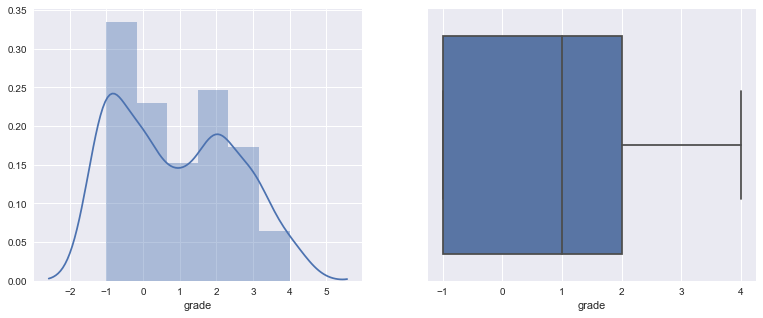

In [98]:
analyze_feature(crew_df_modeling, "grade")

## Start a data frame to store grades, to compare between various models

In [99]:
grade_comp_fulldata = crew_df_modeling.copy()
grade_comp_fulldata.rename(columns={'grade': 'ManualGrade'}, inplace=True)

print(grade_comp_fulldata.shape)

# scale data columns to the 0-1 scale used by the models
for i in range(0, len(grade_comp_fulldata.columns)):
    data = grade_comp_fulldata[grade_comp_fulldata.columns[i]]
    
    if data.dtype != 'object':  # don't scale text columns
        if data.max() != 0:  # divide by zero error
            grade_comp_fulldata[grade_comp_fulldata.columns[i]] = data/data.max()
            
grade_comp_fulldata['ManualGrade'] = grade_comp_fulldata['ManualGrade']*4   # can't figure out how not to scale "grade". blurgh

grade_comp_fulldata.head()

(355, 40)


,CharacterDesignName,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,FireResistance,WalkingSpeed,...,DamageToSameRoomCharacters,DeductReload,FireWalk,Freeze,HealRoomHp,HealSameRoomCharacters,HealSelfHp,None,SetFire,ManualGrade
0,Laura,0.428571,0.72,0.38,0.485714,0.153846,0.241379,0.107143,0.01,0.333333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Lisa,0.428571,0.72,0.38,0.485714,0.269231,0.413793,0.142857,0.01,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Michelle,0.428571,0.72,0.38,0.485714,0.500000,0.137931,0.107143,0.01,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
3,Bobby,0.428571,0.72,0.38,0.485714,0.115385,0.103448,0.500000,0.01,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Edward,0.428571,0.72,0.38,0.485714,0.115385,0.206897,0.142857,0.01,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# data table for model evaluation
grade_comp_data = grade_comp_fulldata.drop(['CharacterDesignName', 'ManualGrade'], axis = 1).values

grade_comp_results = grade_comp_fulldata[['CharacterDesignName', 'ManualGrade']]

## Last bit of data cleansing:

###  get rid of un-graded crew

In [101]:
model_data = crew_df_modeling[crew_df_modeling.grade != -1]
print(model_data.shape)
model_data.head(10)

(256, 40)


,CharacterDesignName,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,FireResistance,WalkingSpeed,...,DamageToSameRoomCharacters,DeductReload,FireWalk,Freeze,HealRoomHp,HealSameRoomCharacters,HealSelfHp,None,SetFire,grade
0,Laura,6,18,1.9,1.7,4.0,7,3.0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,Lisa,6,18,1.9,1.7,7.0,12,4.0,1,1,...,0,0,0,0,0,0,1,0,0,0
2,Michelle,6,18,1.9,1.7,13.0,4,3.0,1,1,...,0,0,0,0,0,1,0,0,0,2
3,Bobby,6,18,1.9,1.7,3.0,3,14.0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Edward,6,18,1.9,1.7,3.0,6,4.0,1,1,...,0,0,0,0,0,0,0,0,0,0
5,Tony,6,18,1.9,1.7,2.0,4,7.0,1,1,...,0,0,0,0,1,0,0,0,0,0
6,Green Ranger - Oliver,9,3,2.8,2.4,7.0,21,6.0,1,1,...,1,0,0,0,0,0,0,0,0,1
7,Engineer Bob,7,3,1.7,3.0,6.0,6,24.0,1,1,...,0,0,0,0,1,0,0,0,0,0
9,Mr Coconut,7,15,2.7,2.5,25.0,18,18.0,1,1,...,0,1,0,0,0,0,0,0,0,3
10,Verunus,6,12,2.6,2.0,15.0,12,3.0,1,1,...,0,0,0,0,0,1,0,0,0,2


### normalize all columns to [0,1] values

In [102]:
for i in range(0, len(model_data.columns)):
    data = model_data[model_data.columns[i]]
    
    if data.dtype != 'object':  # don't scale text columns
        if data.max() != 0:  # divide by zero error
            model_data[model_data.columns[i]] = data/data.max()

        
model_data['grade'] = model_data['grade']*4   # can't figure out how not to scale "grade". blurgh

C:\Users\Krissy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Krissy\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [103]:
model_data.head()

,CharacterDesignName,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,FireResistance,WalkingSpeed,...,DamageToSameRoomCharacters,DeductReload,FireWalk,Freeze,HealRoomHp,HealSameRoomCharacters,HealSelfHp,None,SetFire,grade
0,Laura,0.428571,0.72,0.38,0.515152,0.153846,0.259259,0.111111,0.01,0.333333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Lisa,0.428571,0.72,0.38,0.515152,0.269231,0.444444,0.148148,0.01,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Michelle,0.428571,0.72,0.38,0.515152,0.500000,0.148148,0.111111,0.01,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
3,Bobby,0.428571,0.72,0.38,0.515152,0.115385,0.111111,0.518519,0.01,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Edward,0.428571,0.72,0.38,0.515152,0.115385,0.222222,0.148148,0.01,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Let's try a model! Linear Regression first

In [104]:
# create a random arrangement of the data sets
np.random.seed(0)
labels = model_data['grade'].values

shuffle = np.random.permutation(np.arange(len(labels)))
labels[shuffle]

[ 0.  0.  2.  0.  0.  0.  1.  0.  3.  2.  3.  3.  2.  2.  1.  2.  3.  3.
  3.  2.  1.  2.  0.  1.  0.  1.  2.  2.  3.  3.  2.  4.  1.  2.  2.  3.
  1.  2.  2.  0.  0.  2.  2.  2.  2.  3.  1.  3.  1.  3.  0.  1.  2.  1.
  1.  1.  0.  1.  1.  1.  2.  3.  4.  3.  3.  3.  4.  4.  4.  1.  1.  2.
  1.  0.  1.  0.  2.  2.  1.  1.  3.  3.  4.  4.  4.  4.  2.  2.  2.  0.
  0.  2.  0.  1.  4.  3.  2.  3.  2.  0.  1.  3.  1.  3.  3.  0.  2.  0.
  4.  2.  1.  1.  2.  4.  2.  2.  4.  1.  1.  3.  2.  3.  3.  0.  3.  1.
  3.  2.  3.  4.  3.  2.  2.  4.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  2.  0.  3.  2.  0.  3.  3.  3.  3.  2.  2.  1.
  2.  4.  0.  1.  2.  0.  0.  3.  3.  1.  3.  2.  2.  2.  2.  4.  2.  3.
  0.  3.  1.  3.  2.  2.  2.  1.  2.  2.  3.  3.  2.  0.  0.  2.  0.  2.
  4.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  2.  1.  0.  2.  3.  2.  1.  1.  2.  4.  2.
  2.  2.  1.  3.  3.  0.  2.  3.  2.  0.  2.  3.  3

In [105]:
# Pull out 80% of data points for training. Use 20% for test
np.random.seed(0)
shuffle = np.random.permutation(np.arange(len(model_data['grade'].values)))

features = model_data.drop(['CharacterDesignName', 'grade'], axis = 1).values[shuffle]
labels = model_data['grade'].values[shuffle]

n = len(shuffle)
split_n = int(np.floor(0.8*n))

train_features = features[0:split_n]
train_labels = labels[0:split_n]
test_features = features[split_n+1:]
test_labels = labels[split_n+1:]

print(len(train_labels))
print(len(test_labels))

204
51


In [106]:
from sklearn.linear_model import LinearRegression

# linear regression model
Regmodel = LinearRegression()
Regmodel.fit(train_features, train_labels)

print("The linear regression model achieves an R2 value of " + str(Regmodel.score(test_features, test_labels)))

y_pred = Regmodel.predict(test_features)
print("At worst, the predicted score was off by " + str(round(np.max(y_pred - test_labels),3)) + " grades.\n")

The linear regression model achieves an R2 value of 0.762261934169
At worst, the predicted score was off by 0.804 grades.



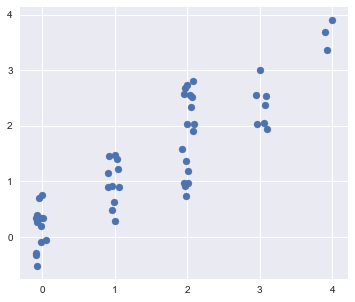

In [107]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred)

In [108]:
# what are the most important features?
coefs = Regmodel.coef_
top_feat_inds = np.fliplr([np.argsort(coefs)[-7:]])[0]
bottom_feat_inds = np.argsort(coefs)[0:7]

# features that bring rating up
for i in top_feat_inds:
    print("The feature " + model_data.columns.tolist()[i+1] +   # one label later, since we dropped CrewNames after model_data
          " has a coefficient of " +  str(coefs[i]))
print("\n")
# features that bring rating down
for i in bottom_feat_inds:
    print("The feature " + model_data.columns.tolist()[i+1] + 
          " has a coefficient of " +  str(coefs[i]))

The feature Common has a coefficient of 4.53656495997e+12
The feature Legendary has a coefficient of 4.53656495997e+12
The feature Hero has a coefficient of 4.53656495997e+12
The feature Epic has a coefficient of 4.53656495997e+12
The feature Special has a coefficient of 4.53656495997e+12
The feature Unique has a coefficient of 4.53656495997e+12
The feature None has a coefficient of 1.11414228798e+12


The feature Elite has a coefficient of -940997658438.0
The feature FinalAttack has a coefficient of -1.21145032972
The feature FinalRepair has a coefficient of -0.551960561612
The feature RunSpeed has a coefficient of -0.452272463481
The feature TrainingCapacity has a coefficient of -0.184829223649
The feature AbilityScore_norm has a coefficient of -0.0701966351866
The feature FinalEngine has a coefficient of -0.00641751179838


### Run the model on all data, and output to the grade comparison table

In [115]:
y_pred = Regmodel.predict(grade_comp_data)
grade_comp_results['LR_grades'] = y_pred.astype(int)

       CharacterDesignName   LR_grades
0                    Laura           0
1                     Lisa           0
2                 Michelle           1
3                    Bobby           0
4                   Edward           0
5                     Tony           0
6    Green Ranger - Oliver           1
7             Engineer Bob           0
8         Big Football Fan -2147483648
9               Mr Coconut           3
10                 Verunus           1
11           Menga Linuxer           3
12           Visiri Capt'n           2
13                  Medusa           2
14                    Doge           2
15              Serge Eric           0
16                   Robot           1
17                    Yusi           2
18                     Xin           2
19                    Monk -2147483648
20                 Roborob           3
21                   Steve           2
22                     Lin           1
23                    Hulk           2
24                Michell

C:\Users\Krissy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Let's try kNN

In [116]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1,3,5,7,9]

for k in k_values:  
    
    kNN = KNeighborsClassifier(n_neighbors = k)
    kNN.fit(train_features, train_labels)
    
    # take a stab at the test set
    y_pred = kNN.predict(test_features)
    # accuracy
    acc = round(sum(y_pred == test_labels)/test_labels.shape[0],3)*100
    
    # what if you consider +/- 1 star to be still "accurate"?
    acc2 = round((
        sum(y_pred == test_labels) + 
        sum(y_pred == test_labels-1) + sum(y_pred == test_labels+1)
        )/test_labels.shape[0],3)*100
    print("The kNN classifier with k=" + str(k) + " had an accuracy of " 
          + str(acc) + "% (and a +/-1 grade accuracy of " + str(acc2) + "%)." )

    
# use the best model: n = 7
kNN = KNeighborsClassifier(n_neighbors = 7)
kNN.fit(train_features, train_labels)

# print the values the model gets wrong
print("\nThe ratings misclassified by the classifier were: ")
y_pred = kNN.predict(test_features)
errors = test_labels[y_pred != test_labels]
print(str(errors) + "-- actual values")
print(str(y_pred[y_pred != test_labels]) + "-- predicted values")

The kNN classifier with k=1 had an accuracy of 51.0% (and a +/-1 grade accuracy of 94.1%).
The kNN classifier with k=3 had an accuracy of 54.9% (and a +/-1 grade accuracy of 84.3%).
The kNN classifier with k=5 had an accuracy of 56.9% (and a +/-1 grade accuracy of 88.2%).
The kNN classifier with k=7 had an accuracy of 56.9% (and a +/-1 grade accuracy of 90.2%).
The kNN classifier with k=9 had an accuracy of 52.9% (and a +/-1 grade accuracy of 94.1%).

The ratings misclassified by the classifier were: 
[ 2.  4.  0.  1.  2.  2.  2.  1.  3.  2.  0.  1.  1.  1.  2.  2.  2.  3.
  4.  1.  3.  3.]-- actual values
[ 3.  2.  2.  2.  1.  3.  3.  3.  0.  3.  1.  2.  0.  0.  3.  1.  1.  2.
  2.  0.  2.  2.]-- predicted values


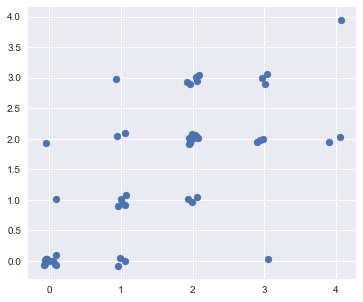

In [117]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred+0.1-np.random.uniform(size=len(y_pred))*0.2)

## Run model on all data, and output to grade comparison table

In [118]:
y_pred = kNN.predict(grade_comp_data)
grade_comp_results['kNN_grades'] = y_pred.astype(int)

C:\Users\Krissy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Write grade comparison table to excel

In [147]:
with pd.ExcelWriter('grades_comp.xlsx') as writer:
    grade_comp_results.to_excel(writer, sheet_name = "grade_comparison")
    
    # print the weird LR results to excel
    weird_results_names = grade_comp_results[grade_comp_results.LR_grades < 0].CharacterDesignName.values

    weird_results = crew_df[crew_df.CharacterDesignName.isin(weird_results_names)]
    weird_results.to_excel(writer, sheet_name = "WeirdLRResults")